In [1]:
# Installing required libraries
# !pip install numpy pandas soundfile librosa openpyxl pytorch torchaudio

In [2]:
# Importing required libraries
import librosa
import numpy as np
import pandas as pd
import IPython.display as ipd
import soundfile as sf
import os
import torch, torchaudio
import matplotlib.pyplot as plt
import re

In [3]:
# Reading the file
df = pd.read_csv('slakh2100_metadata.csv')
df.head()

Folder Name                              UUID Track Name  \
0  Track00001  1a81ae092884234f3264e2f45927f00a    S00.wav   
1  Track00001  1a81ae092884234f3264e2f45927f00a    S01.wav   
2  Track00001  1a81ae092884234f3264e2f45927f00a    S02.wav   
3  Track00001  1a81ae092884234f3264e2f45927f00a    S03.wav   
4  Track00001  1a81ae092884234f3264e2f45927f00a    S04.wav   

      Instrument Class       MIDI Program Name  Integrated Loudness  Is Drum  \
0               Guitar       Distortion Guitar           -12.820742    False   
1                Drums                   Drums           -27.129534     True   
2                Piano   Bright Acoustic Piano           -16.590527    False   
3                 Bass  Electric Bass (finger)           -21.676179    False   
4  Strings (continued)              Choir Aahs           -17.157878    False   

                                Plugin Name  Program Number  Unnamed: 9  
0                       elektrik_guitar.nkm              30           1  
1                      session_kit_full.nkm             128           3  
2               the_giant_modern_studio.nkm               1           2  
3  scarbee_rickenbacker_bass_palm_muted.nkm              33           4  
4                               choir_o.nkm              52           5

In [4]:
# Four main instruments
four_instr = ['Piano', 'Drums', 'Bass', 'Guitar']

# Unique track folders
unique_tracks = df['Folder Name'].unique()
print(unique_tracks)

['Track00001' 'Track00002' 'Track00003']


In [5]:
# Replacing all the instruments except in ['Piano', 'Drums', 'Bass', 'Guitar'] with 'Others' tag
def replace_other_track_labels(df, four_instr):
  try:
    df['Instrument Class'] = np.where(~df['Instrument Class'].isin(four_instr), 'Others', df['Instrument Class'])
    return df
  except Exception as e:
    print(f"Error encounterd in function 'replace_other_track_labels'.")
    raise e

In [6]:
df = replace_other_track_labels(df, four_instr)
df[df['Folder Name'] == 'Track00001'].head(6)

Folder Name                              UUID Track Name Instrument Class  \
0  Track00001  1a81ae092884234f3264e2f45927f00a    S00.wav           Guitar   
1  Track00001  1a81ae092884234f3264e2f45927f00a    S01.wav            Drums   
2  Track00001  1a81ae092884234f3264e2f45927f00a    S02.wav            Piano   
3  Track00001  1a81ae092884234f3264e2f45927f00a    S03.wav             Bass   
4  Track00001  1a81ae092884234f3264e2f45927f00a    S04.wav           Others   
5  Track00001  1a81ae092884234f3264e2f45927f00a    S05.wav           Others   

        MIDI Program Name  Integrated Loudness  Is Drum  \
0       Distortion Guitar           -12.820742    False   
1                   Drums           -27.129534     True   
2   Bright Acoustic Piano           -16.590527    False   
3  Electric Bass (finger)           -21.676179    False   
4              Choir Aahs           -17.157878    False   
5        Percussive Organ           -16.600870    False   

                                Plugin Name  Program Number  Unnamed: 9  
0                       elektrik_guitar.nkm              30           1  
1                      session_kit_full.nkm             128           3  
2               the_giant_modern_studio.nkm               1           2  
3  scarbee_rickenbacker_bass_palm_muted.nkm              33           4  
4                               choir_o.nkm              52           5  
5                                 fever.nkm              17           5

In [ ]:
# Making the length of every audio equal to 180 seconds
def make_lengths_sample(audio_file, sample_rate, target_duration=180):
    try:
        # Finding the length of input audio
        audio_length = len(audio_file)
        
        # Finding the target length in number of samples
        target_length = int(sample_rate * target_duration)
        
        if audio_length < target_length:  # If audio duration is less than 180 seconds
            padding = target_length - audio_length # Finding how much padding is required
            padding_left = 0  # Padding with zero
            padding_right = padding # Padding from the right side
            audio_file = np.pad(audio_file, (padding_left, padding_right), mode='constant', constant_values=0) # Padding
        
        elif audio_length > target_length: # If audio duration is greater than 180 seconds
            audio_file = audio_file[:target_length] # Cutting down the excess audio 

        return audio_file
    except Exception as e:
        print(f"Error encounterd in the function 'make_lengths_sample'.")
        raise e

In [ ]:
def merge_tracks(track_df, instrument):
  
  try:
    # Filtering the track_df dataframe to get only the records with required instrument
    instr_df = track_df[track_df['Instrument Class'] == instrument]

    # If the required instrument is not present, return None
    if instr_df.shape[0] == 0:
      print(f"No matching instrument found for '{instrument}'") 
      print("Available instruments:", track_df['Instrument Class'].unique()) 
      return None, None
      
    # Loading the first record corresponding to the required instrument
    y, sr = librosa.load(os.path.join('RawData', instr_df.iloc[0, 0], 'stems' ,instr_df.iloc[0, 2]), mono=True, sr=10880)
  
    # Changing the duration of first record to appropriate value
    y = make_lengths_sample(y, sr)
    
    # If there is more than one record corresponding to the required instrument, then they are merged together
    if instr_df.shape[0] > 1:
      for index in range(1, instr_df.shape[0]):
        y_next, sr_next = librosa.load(os.path.join('RawData', instr_df.iloc[index, 0], 'stems' , instr_df.iloc[index, 2]), mono=True, sr=10880)
        
        y_next = make_lengths_sample(y_next, sr_next)

        y += y_next
        
      # Normalizing the audio
      y /= np.max(np.abs(y))
  
    return y, sr
  
  except Exception as e:
    print("Error encounterd in the function 'merge_tracks'.")
    raise e

In [9]:
def merge_main_four_tracks(unique_track):

  try:
    # Filtering the data for the particular track
    track_df = df[df['Folder Name'] == unique_track]

    # Merging the piano records if required
    y_piano, sr_piano = merge_tracks(track_df, 'Piano')
    y_piano = y_piano.reshape(-1, 1) # reshaping because soundfile expects the shape of (audio_samples, num_channels)
    
    # Merging guitar records if required
    y_guitar, sr_guitar = merge_tracks(track_df, 'Guitar')
    y_guitar = y_guitar.reshape(-1, 1) # reshaping because soundfile expects the shape of (audio_samples, num_channels)

    # Merging the bass records if required
    y_bass, sr_bass = merge_tracks(track_df, 'Bass')
    y_bass = y_bass.reshape(-1, 1) # reshaping because soundfile expects the shape of (audio_samples, num_channels)

    # Merging the drum records if required
    y_drums, sr_drums = merge_tracks(track_df, 'Drums')
    y_drums = y_drums.reshape(-1, 1) # reshaping because soundfile expects the shape of (audio_samples, num_channels)

    return y_piano, y_guitar, y_bass, y_drums, sr_piano, sr_guitar, sr_bass, sr_drums
  
  except Exception as e:
    print("Error encountered in the function 'merge_main_four_tracks'.")
    raise e

In [ ]:
def create_audio_dataset(unique_tracks, four_instr=['Piano', 'Drums', 'Bass', 'Guitar']):
  
  try:
    # If the folder to store the data is not present then it is created
    if not os.path.exists('Audio_Dataset'):
      os.makedirs('Audio_Dataset')
      
    # Creating input and output folder
    if not os.path.exists(os.path.join('Audio_Dataset', 'Input')):
      os.makedirs(os.path.join('Audio_Dataset', 'Input'))
      
    if not os.path.exists(os.path.join('Audio_Dataset', 'Output')):
      os.makedirs(os.path.join('Audio_Dataset', 'Output'))

    for unique_track in unique_tracks: # For every unique trackk
      track_df = df[df['Folder Name'] == unique_track] # Filtering the data base on the unique track
      if all(True for instr in four_instr if instr in track_df['Instrument Class']): # If all the four main instruments are present in the mixed audio
        
        # Merging the multiple audio files of same instrument if required
        y_piano, y_guitar, y_bass, y_drums, sr_piano, sr_guitar, sr_bass, sr_drums = merge_main_four_tracks(unique_track)
        
        # Creating a folder for each unique track if it is not already present
        if not os.path.exists(os.path.join('Audio_Dataset', 'Output', str(unique_track))):
          os.makedirs(os.path.join('Audio_Dataset', 'Output' ,str(unique_track)))

        # Saving all four main audio files
        if y_piano is not None and sr_piano is not None:
          sf.write(os.path.join('Audio_Dataset', 'Output',  str(unique_track), 'Piano.wav'), y_piano, sr_piano)
          
        if y_drums is not None and sr_drums is not None:
          sf.write(os.path.join('Audio_Dataset', 'Output' , str(unique_track), 'Drum.wav'), y_drums, sr_drums)
          
        if y_bass is not None and sr_bass is not None:
          sf.write(os.path.join('Audio_Dataset', 'Output' , str(unique_track), 'Bass.wav'), y_bass, sr_bass)
          
        if y_guitar is not None and sr_guitar is not None:
          sf.write(os.path.join('Audio_Dataset', 'Output' , str(unique_track), 'Guitar.wav'), y_guitar, sr_guitar)
                    
      # If there is not other instrument present other than the main four then dummy others audio is created.
      if 'Others' not in track_df.iloc[:, 3].unique():
        y_others = np.zeros(int(180 * 10880)).reshape(-1, 1)
        sr_others = 10880
      else:
        y_others, sr_others = merge_tracks(track_df, 'Others')
      
      # Saving others audio
      if y_others is not None and sr_others is not None:
        sf.write(os.path.join('Audio_Dataset', 'Output' , str(unique_track), 'Others.wav'), y_others, sr_others)
        
      # Saving the mixed audio
      y_mix, sr_mix = librosa.load(os.path.join('RawData', str(unique_track), 'mix.wav'), mono=True, sr=10880)
      
      if y_mix is not None and sr_mix is not None:
        sf.write(os.path.join('Audio_Dataset', 'Input', f'{unique_track}_mix.wav'), y_mix, sr_mix)
        
  except Exception as e:
    print("Error encountered in the 'create_dataset' function.")

In [11]:
# Creating the dataset
create_audio_dataset(unique_tracks)

In [12]:
def create_mel_spectrogram(waveform, window_length, hop_length, n_mels, sample_rate, top_db):
    # Ensure waveform is a torch tensor
    if not isinstance(waveform, torch.Tensor):
        waveform = torch.tensor(waveform, dtype=torch.float32)
    
    # Ensure correct shape: (channels, samples)
    if waveform.ndim == 1:
        waveform = waveform.unsqueeze(0)  # Add channel dimension if missing
    
    # Validate tensor dimensions
    if waveform.ndim != 2:
        raise ValueError(f"Waveform must be 2D (channels, samples), got shape {waveform.shape}")
    
    # Define the MelSpectrogram transform 
    mel_spectrogram_transform = torchaudio.transforms.MelSpectrogram( 
        sample_rate=sample_rate, 
        n_fft=window_length, 
        hop_length=hop_length, 
        n_mels=n_mels, 
        window_fn=torch.hann_window
    )
    
    # Apply the transform to the waveform 
    mel_spectrogram = mel_spectrogram_transform(waveform) 
    
    # Convert to decibel scale for better visualization 
    mel_spectrogram_db = torchaudio.transforms.AmplitudeToDB(top_db=top_db)(mel_spectrogram)
    
    return mel_spectrogram_db

In [13]:
def create_spectrogram_dataset(unique_tracks, four_instr=['Piano', 'Drums', 'Bass', 'Guitar']):
    try:
        # If the folder to store the data is not present then it is created
        if not os.path.exists('Spectrogram_Dataset'):
            os.makedirs('Spectrogram_Dataset')
        
        # Creating input and output folder
        if not os.path.exists(os.path.join('Spectrogram_Dataset', 'Input')):
            os.makedirs(os.path.join('Spectrogram_Dataset', 'Input'))
        
        if not os.path.exists(os.path.join('Spectrogram_Dataset', 'Output')):
            os.makedirs(os.path.join('Spectrogram_Dataset', 'Output'))

        for unique_track in unique_tracks: # For every unique trackk
            track_df = df[df['Folder Name'] == unique_track] # Filtering the data base on the unique track
            if all(True for instr in four_instr if instr in track_df['Instrument Class']): # If all the four main instruments are present in the mixed audio
                
                # Merging the multiple audio files of same instrument if required
                y_piano, y_guitar, y_bass, y_drums, sr_piano, sr_guitar, sr_bass, sr_drums = merge_main_four_tracks(unique_track)

                # Creating a folder for each unique track if it is not already present
                if not os.path.exists(os.path.join('Spectrogram_Dataset', 'Output', str(unique_track))):
                    os.makedirs(os.path.join('Spectrogram_Dataset', 'Output' ,str(unique_track)))
                    
                # If there is not other instrument present other than the main four then dummy others audio is created.
                if 'Others' not in track_df.iloc[:, 3].unique():
                    y_others = np.zeros(int(180 * 10880)).reshape(-1, 1)
                    sr_others = 10880
                else:
                    y_others, sr_others = merge_tracks(track_df, 'Others')
                    
                y_mix, sr_mix = librosa.load(os.path.join('RawData', str(unique_track), 'mix.wav'), mono=True, sr=10880)
                
                # Defining the parameters for the mel spectrogram
                window_length = 1024
                hop_length = 512
                n_mels = 128
                sample_rate = 10880
                top_db = 110
                hann_window = torch.hann_window(window_length)
                
                # for input audio
                # performing short time fourier transform (STFT) with hanning window
                y_mix = y_mix.reshape(1, -1) # torchaudio needs the shape (num_channels, num_samples)
                
                input_mel_spectrogram_db = create_mel_spectrogram(y_mix, window_length, hop_length, n_mels, sample_rate, top_db)
                
                # plotting and saving the mel-spectrogram
                plt.figure(figsize=(10, 4))
                plt.imshow(input_mel_spectrogram_db[0].numpy(), aspect='auto', origin='lower', interpolation=None,  cmap='viridis')
                plt.colorbar(format='%+2.0f dB')
                plt.tight_layout()
                plt.savefig(os.path.join('Spectrogram_Dataset', 'Input', f"{unique_track}_mix.png"))
                
                outputs = [y_piano, y_guitar, y_bass, y_drums, y_others]
                instr_names = ['Piano', 'Guitar', 'Bass', 'Drums', 'Others']
                # for output audios
                for index, output in enumerate(outputs):
                    output = output.reshape(1, -1) # torchaudio needs the shape (num_channels, num_samples)
                    output_mel_spectrogram_db = create_mel_spectrogram(output, window_length, hop_length, n_mels, sample_rate, top_db)
                    
                    # plotting and saving the mel-spectrogram
                    plt.figure(figsize=(10, 4))
                    plt.imshow(output_mel_spectrogram_db[0].numpy(), aspect='auto', origin='lower', interpolation=None,  cmap='viridis')
                    plt.colorbar(format='%+2.0f dB')
                    plt.tight_layout()
                        
                    plt.savefig(os.path.join('Spectrogram_Dataset', 'Output', str(unique_track), f"{instr_names[index]}.png"))
                    
    except Exception as e:
        print("Error encountered in the function 'create_spectrogram_dataset'.")
        raise e
                    
                

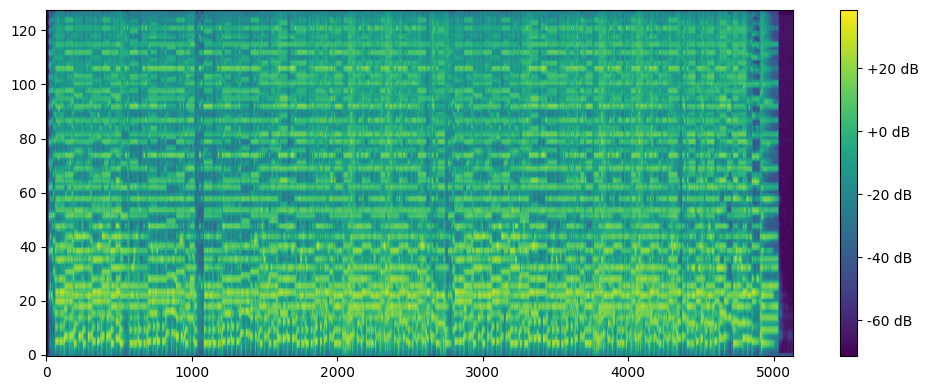

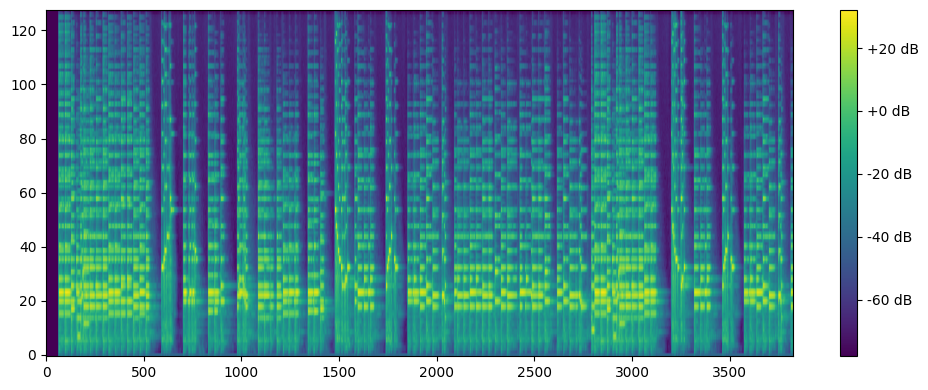

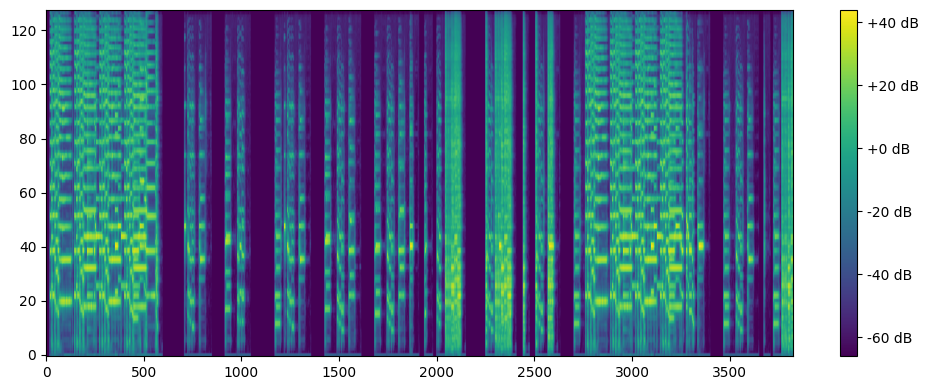

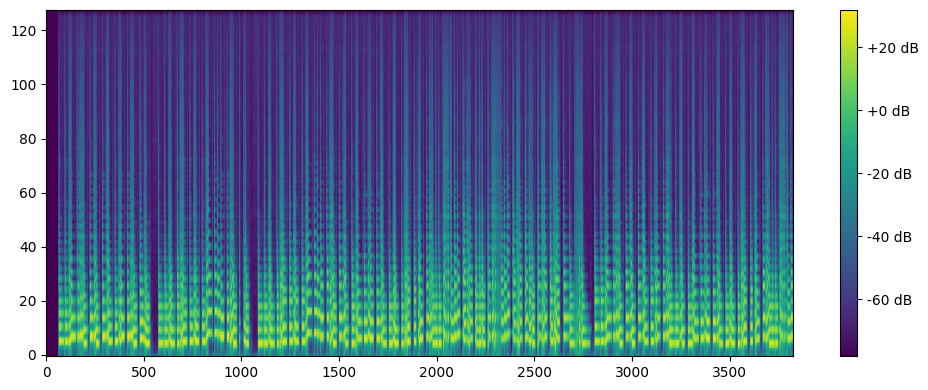

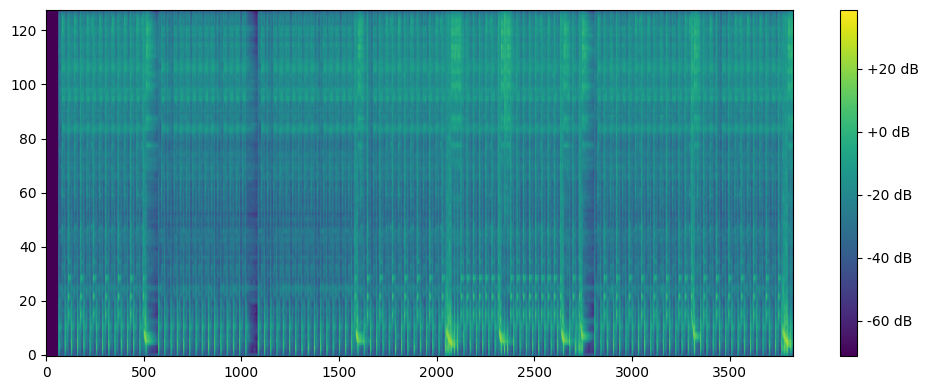

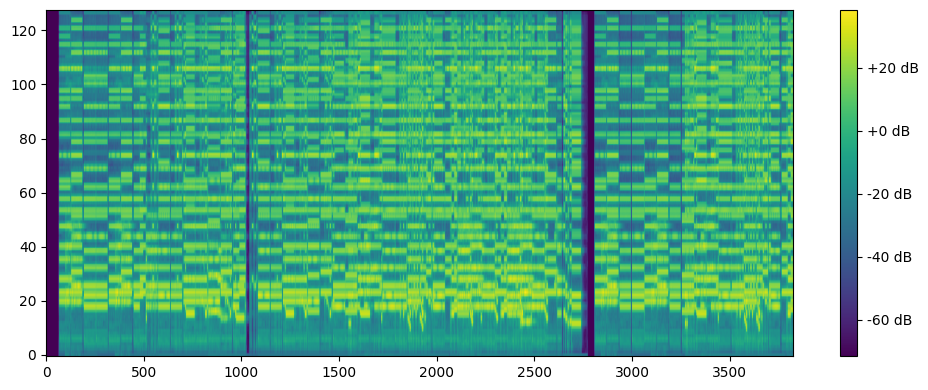

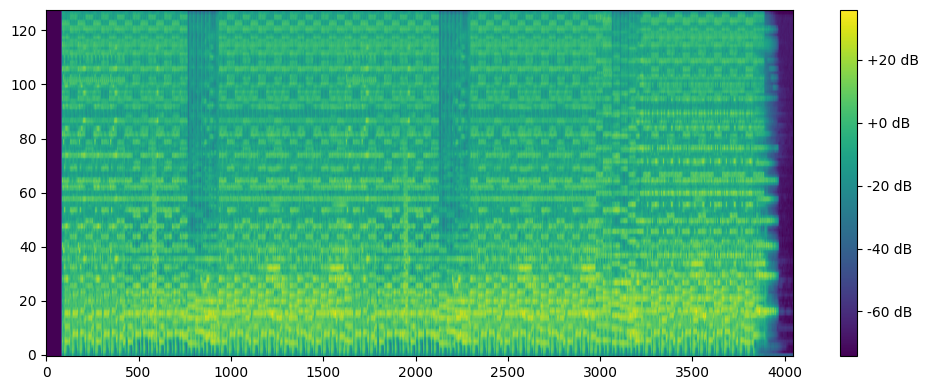

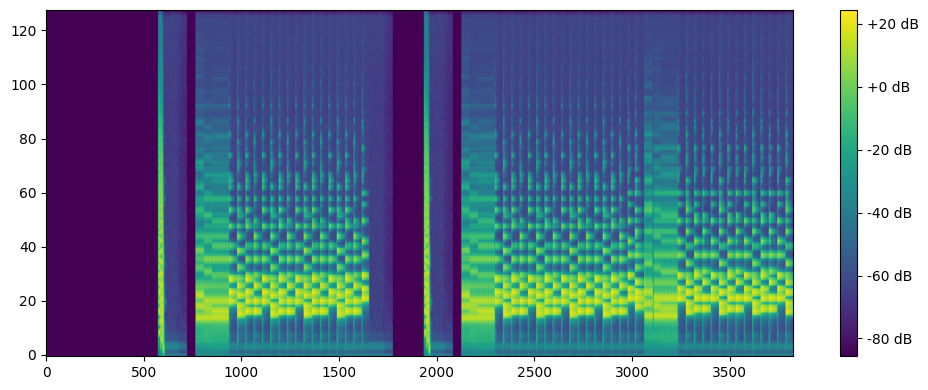

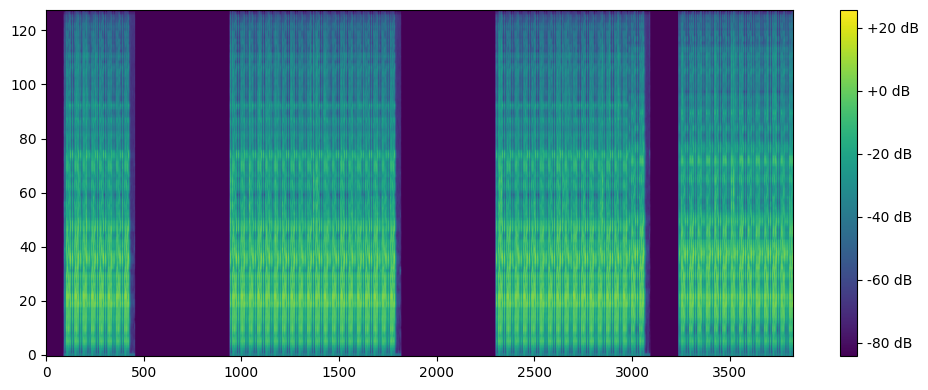

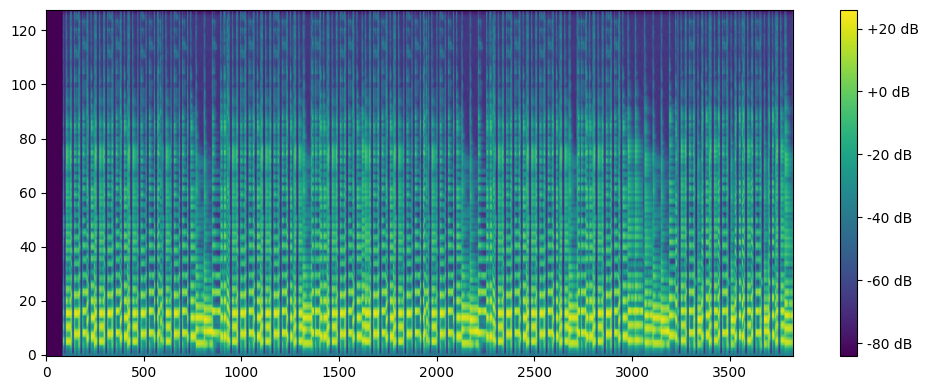

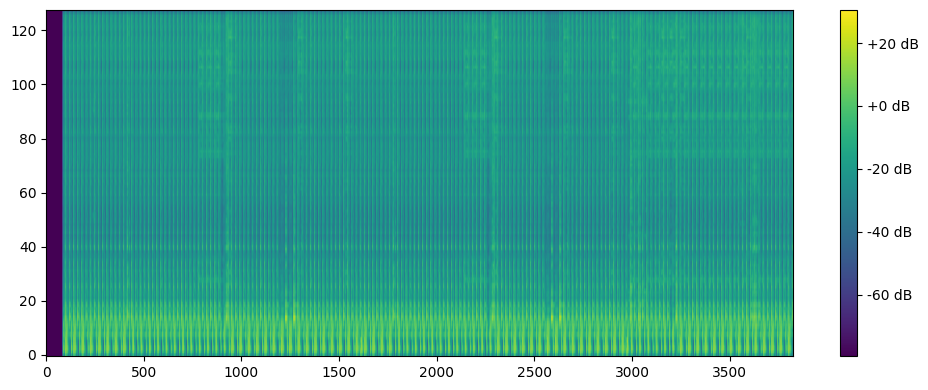

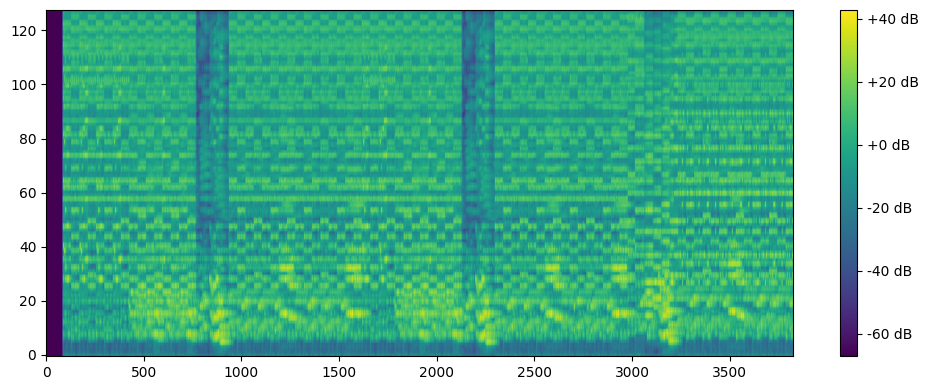

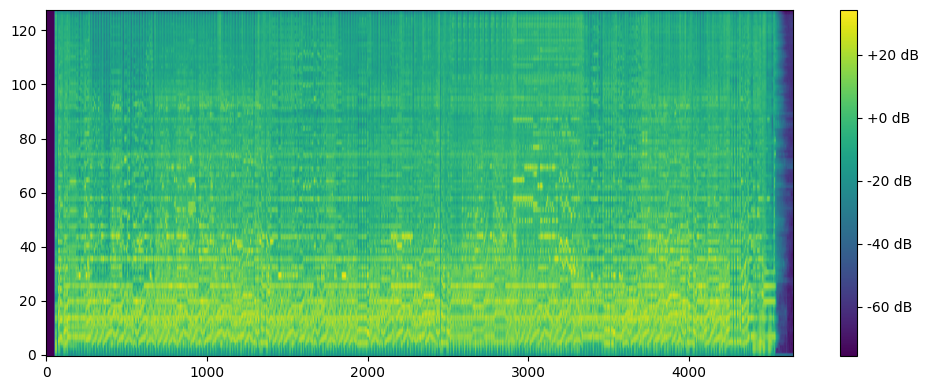

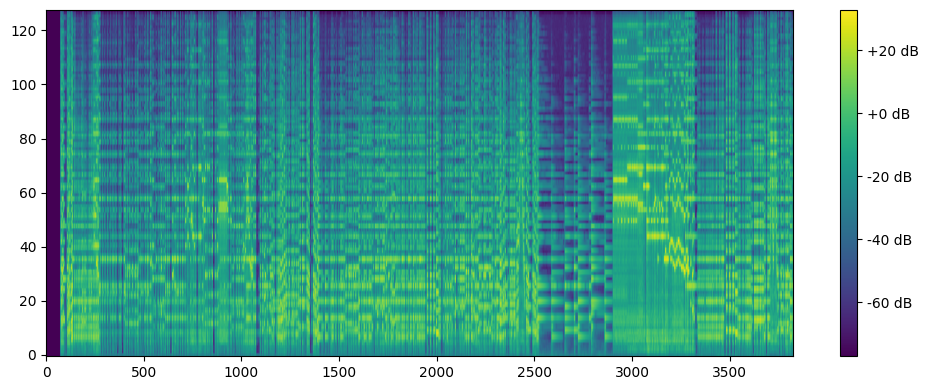

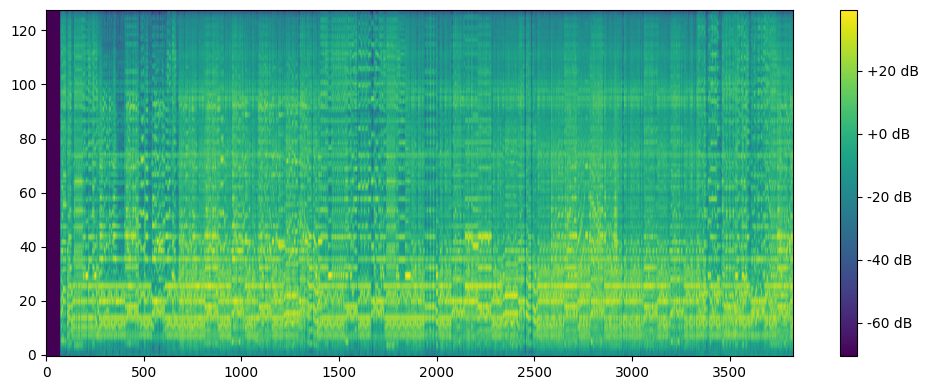

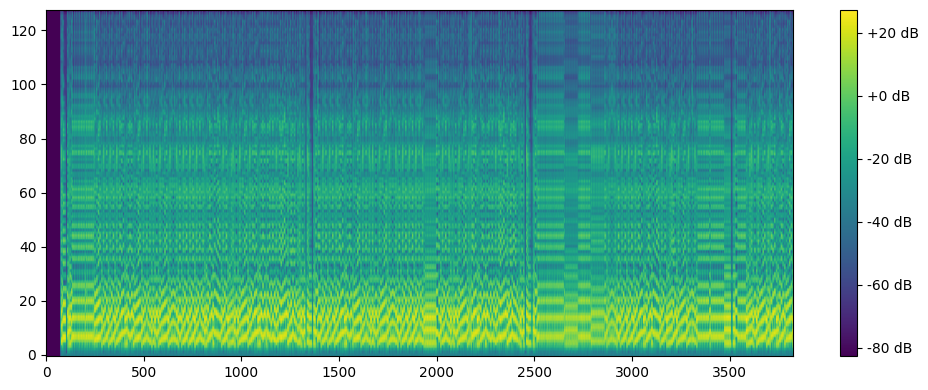

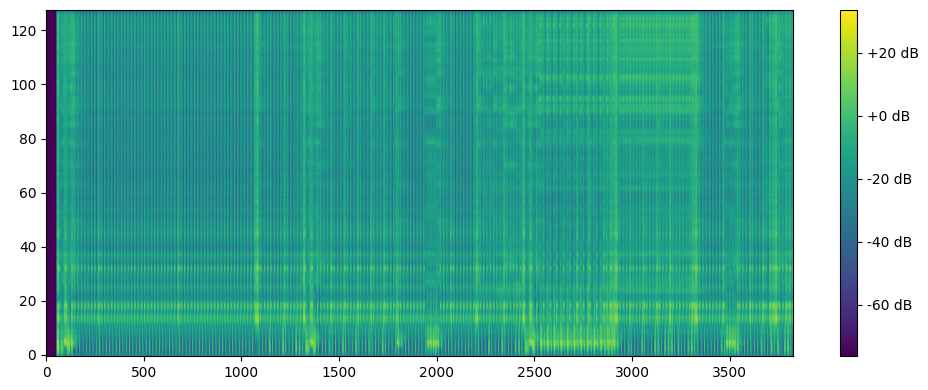

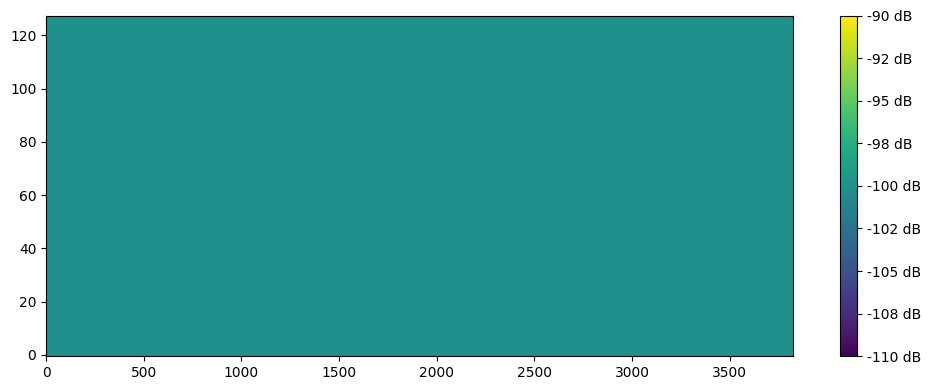

In [14]:
create_spectrogram_dataset(unique_tracks, four_instr=['Piano', 'Drums', 'Bass', 'Guitar'])